In [1]:
import torch
import os
from typing import List
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import albumentations as A
import numpy as np
import albumentations.pytorch as al_pytorch
from typing import Dict, Tuple
import pytorch_lightning as pl
torch.__version__

'1.11.0+cpu'

## Number of images

In [2]:
DATA_ROOT_PATH:str = "/kaggle/input/anime-sketch-colorization-pair/data/"
NO_OF_IMAGES:int = 5 # Limit the number of images
#
train_path:str = f"{DATA_ROOT_PATH}train/"
train_images:List[str] = [ f"{train_path}{x}" for x in os.listdir(train_path) ][:NO_OF_IMAGES]
test_path:str = f"{DATA_ROOT_PATH}val/"
test_images:List[str] = [ f"{test_path}{x}" for x in os.listdir(test_path) ][:NO_OF_IMAGES]
#
print(" Nb of train images : " + str(len(train_images)))
print(" Nb of test images : " + str(len(test_images)))

 Nb of train images : 5
 Nb of test images : 5


## Let's plot a few images

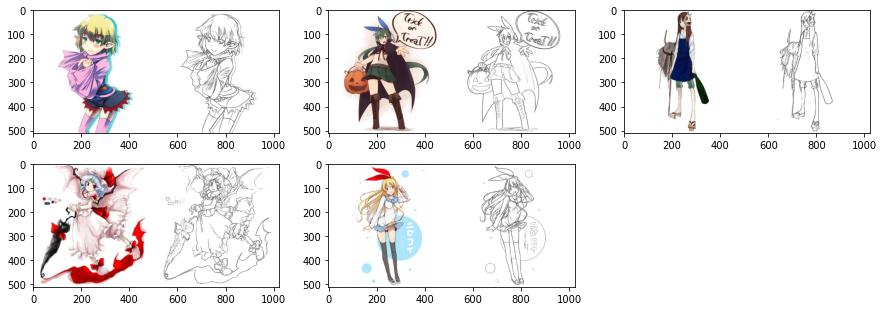

In [3]:
plt.figure(figsize=(15,8))
for i, img_path in enumerate(train_images[:9]):
    im = Image.open(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(im)

# Create Model

In [4]:
!git clone -b 16-create-v1-add-callback https://github.com/nmud19/thesisGAN.git

Cloning into 'thesisGAN'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 174 (delta 64), reused 107 (delta 27), pack-reused 0
Receiving objects: 100% (174/174), 13.65 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [5]:
os.chdir("thesisGAN")
os.mkdir("/kaggle/working/checkpoints/")
from app.discriminator import patch_gan
from app.generator import unetGen
from app.consume_data import consume_data
from app.model import lit_model

# Set up gen and discriminator

In [6]:
lr = 0.0002
device="gpu"

In [7]:
generator = unetGen.UNET()
discriminator = patch_gan.PatchGan(
    input_channels=6,
    hidden_channels=1
)

# Setup the data

In [8]:
train_dataset, valid_dataset = consume_data.get_dataset(
    train_images=train_images,
    test_images=test_images,
)
train_dataloader, valid_dataloader = consume_data.get_dataloaders(
    train_dataset=train_dataset,
    test_dataset=valid_dataset,
)

The train test dataset lengths are :  5 5


# Add the pytorch lightning script

In [9]:
# Trainer
from app.model.lit_model import Pix2PixLitModule

model = Pix2PixLitModule(
    generator=generator,
    discriminator=discriminator,
    use_gpu=False
)
# Trainer
epoch_inference_callback = lit_model.EpochInference(valid_dataloader, use_gpu=False)
# checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint()
logger = pl.loggers.TensorBoardLogger("tb_logs", name="pix2pix_lightning_model")
trainer = pl.Trainer(
#     fast_dev_run=True,
    max_epochs=5,
    logger=logger,
    callbacks=[
#         epoch_inference_callback,
#         checkpoint_callback,
        pl.callbacks.TQDMProgressBar(refresh_rate=10)
    ],
    default_root_dir="/kaggle/working/checkpoints/",
#     accelerator='gpu', 
#     devices=1
#     gpus=-1
)
trainer.fit(
    model,
    train_dataloader,
#     valid_dataloader
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of t

Training: 0it [00:00, ?it/s]